# PyTorch FoodVision - Bootcamp

## Import or check torch/torchvision versions

In [1]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.1.2
Torchvision version: 0.16.2


## Regular imports

In [2]:
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torch info, install it if it doesn't work
try:
    from torchinfo import summary
except: 
    print("[INFO] Couldn't find torch info... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import pytorch/modules directory, download it from GitHub if it doesn't work
try:
    from pytorch_module_dir.modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    !git clone https://github.com/DarekW90/pytorch_module_dir
    from pytorch_module_dir.modules import data_setup, engine
    from pytorch_module_dir.helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch_module_dir'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 1), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), 10.44 KiB | 2.61 MiB/s, done.


## Setup device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is:{device}\n")
if device == "cuda":
    !nvidia-smi

Device is:cuda

Mon Feb 19 08:59:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+---------

## Create model

In [4]:
def create_vit_model(num_classes:int=3,
                    seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms."""
    
    # Create ViT_B_16 pretrained weights/transfomm and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)
    
    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False
        
    # Change classifier head to suit needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))
    
    return model, transforms

## Set transforms

In [5]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 168MB/s] 


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

## Get data - donwload full Food101 dataset

In [7]:
from pathlib import Path
from torchvision import datasets

data_dir = Path("data")

# Get training data
train_data = datasets.Food101(root=data_dir,
                             split="train",
                             transform=food101_train_transforms,
                             download=True)

# Get test data
test_data = datasets.Food101(root=data_dir,
                            split="test",
                            transform=vit_transforms,
                            download=True)

100%|██████████| 4996278331/4996278331 [00:26<00:00, 189770995.15it/s]


Extracting data/food-101.tar.gz to data


## Get Food101 class names


In [8]:
food101_class_names = train_data.classes

# View first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Split dataset

In [9]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions"""
    
    length_1 = int(len(dataset) * split_size)
    length_2 = int(len(dataset) - length_1)
    
    # print info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                  lengths=[length_1, length_2],
                                                                  generator=torch.manual_seed(seed))
    
    return random_split_1, random_split_2

## Set 20% of data for testing

In [10]:
# Create training split of Food101
train_data_food_101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing split of Food101
test_data_food_101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


In [11]:
print(f"Length of train data - 20% : {len(train_data_food_101_20_percent)}")
print(f"Length of test data - 20% : {len(test_data_food_101_20_percent)}")

Length of train data - 20% : 15150
Length of test data - 20% : 5050


## Set 100% of data for testing

In [12]:
# Create training split of Food101
train_data_food_101_100_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=1)

# Create testing split of Food101
test_data_food_101_100_percent, _ = split_dataset(dataset=test_data,
                                                split_size=1)

[INFO] Splitting dataset of length 75750 into splits of size: 75750 (100%), 0 (0%)
[INFO] Splitting dataset of length 25250 into splits of size: 25250 (100%), 0 (0%)


In [13]:
print(f"Length of train data - 100% : {len(train_data_food_101_100_percent)}")
print(f"Length of test data - 100% : {len(test_data_food_101_100_percent)}")

Length of train data - 100% : 75750
Length of test data - 100% : 25250


## Create dataloaders

In [14]:
from torch.utils.data import DataLoader
import os

In [15]:
# 20% dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_food101_20_percent = DataLoader(train_data_food_101_20_percent,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=NUM_WORKERS)

test_dataloader_food101_20_percent = DataLoader(test_data_food_101_20_percent,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_WORKERS)

In [16]:
# Print number of batches
print(f"Num of batches of train dataloader: {len(train_dataloader_food101_20_percent)}")
print(f"Num of batches of test dataloader: {len(test_dataloader_food101_20_percent)}")

Num of batches of train dataloader: 474
Num of batches of test dataloader: 158


In [17]:
# 100% dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_food101_100_percent = DataLoader(train_data_food_101_100_percent,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 num_workers=NUM_WORKERS)

test_dataloader_food101_100_percent = DataLoader(test_data_food_101_100_percent,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=NUM_WORKERS)

In [18]:
# Print number of batches
print(f"Num of batches of train dataloader: {len(train_dataloader_food101_100_percent)}")
print(f"Num of batches of test dataloader: {len(test_dataloader_food101_100_percent)}")

Num of batches of train dataloader: 2368
Num of batches of test dataloader: 790


# Create ViT model

In [23]:
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

summary(model=vit_food101_20_percent,
       input_size=(1,3,224,224),
       col_names=["input_size", "output_size", "num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Train ViT feature extractor on 20% of Food101 data

In [25]:
from timeit import default_timer as timer

# **WARNING**

# This cell is going to run for around ~2-3min per epoch

(Tesla P100)

In [29]:
LEARNING_RATE = 1e-3
EPOCHS = 5

# loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# optimizer
optimizer = torch.optim.Adam(vit_food101_20_percent.parameters(),
                            lr=LEARNING_RATE)

# train the model
start_time = timer()
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                                             train_dataloader=train_dataloader_food101_20_percent,
                                             test_dataloader=test_dataloader_food101_20_percent,
                                             epochs=EPOCHS,
                                             loss_fn=loss_fn,
                                             optimizer=optimizer,
                                             device=device)

print(f"[INFO] Total training time {round(timer()-start_time,2)}sec")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8456 | train_acc: 0.4291 | test_loss: 2.0698 | test_acc: 0.6243
Epoch: 2 | train_loss: 2.2201 | train_acc: 0.5920 | test_loss: 1.9248 | test_acc: 0.6668
Epoch: 3 | train_loss: 2.0698 | train_acc: 0.6429 | test_loss: 1.8728 | test_acc: 0.6925
Epoch: 4 | train_loss: 1.9516 | train_acc: 0.6781 | test_loss: 1.8458 | test_acc: 0.7029
Epoch: 5 | train_loss: 1.8917 | train_acc: 0.7011 | test_loss: 1.8345 | test_acc: 0.6992
Total training time (699, 2)sec


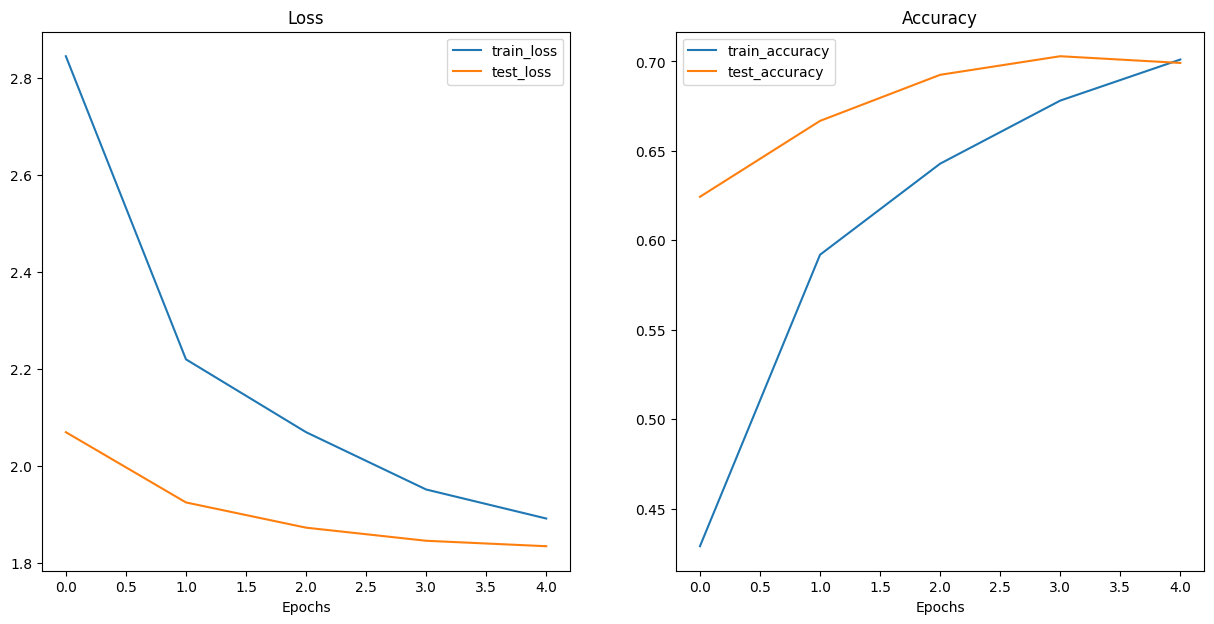

In [30]:
plot_loss_curves(vit_food101_20_percent_results)

# Evaluate model on entire test set

In [46]:
import os
from tqdm.auto import tqdm


NUM_WORKERS = os.cpu_count()

# create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food_101_100_percent,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 num_workers=NUM_WORKERS)

# prepare model
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader to make predictions on each image
vit_food101_20_percent_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
    X, y = X.to(device), y.to(device)
    
    # Create empty dictionary
    pred_dict = {}
    
    # Make predictions
    with torch.inference_mode():
        pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)
        pred_dict["pred_probs"] = torch.max(pred_probs).cpu().numpy()
        pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
        pred_dict["label"] = y.cpu().numpy()[0]
        
    vit_food101_20_percent_pred_list.append(pred_dict)

  0%|          | 0/25250 [00:00<?, ?it/s]

# Making confusion frames

In [64]:
import pandas as pd

pred_df_20_percent = pd.DataFrame(vit_food101_20_percent_pred_list)
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

,pred_probs,pred_label,label,is_correct,pred_class,label_class
0,0.9255542,72,72,True,pancakes,pancakes
1,0.9555763,57,57,True,hummus,hummus
2,0.43247634,14,80,False,carrot_cake,pulled_pork_sandwich
3,0.91977566,51,51,True,guacamole,guacamole
4,0.96004814,1,1,True,baby_back_ribs,baby_back_ribs


# "Most wrong predictions"

In [65]:
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_probs", ascending=False)[:10]

,pred_probs,pred_label,label,is_correct,pred_class,label_class
2848,0.9888581,41,8,False,french_onion_soup,bread_pudding
6065,0.98883075,16,39,False,cheese_plate,foie_gras
10361,0.98858494,67,72,False,omelette,pancakes
20962,0.9839363,69,65,False,oysters,mussels
20400,0.9813814,36,26,False,falafel,crab_cakes
5538,0.9793646,30,95,False,deviled_eggs,sushi
15550,0.97566944,87,71,False,scallops,paella
1306,0.97440726,71,44,False,paella,fried_rice
10611,0.97281533,8,82,False,bread_pudding,ravioli
17137,0.9715099,5,4,False,beet_salad,beef_tartare


# *[NOTE]* As can bee see most wrongs predictions for photos are these food which almost looks the same

## Train Vit feature extractor on 100% of Food101 data

# **WARNING**

# This cell is going to run for around ~10-15min per epoch - uncomment if needed

(Tesla P100)

In [32]:
# LEARNING_RATE = 1e-3
# EPOCHS = 5

# # loss function
# loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# # optimzier
# optimizer = torch.optim.Adam(vit_food101_20_percent.parameters(),
#                             lr=LEARNING_RATE)

# # train the model
# vit_food_100_percent_results = engine.train(model=vit_food101_20_percent,
#                                            train_dataloader=train_dataloader_food101_100_percent,
#                                            test_dataloader=test_dataloader_food101_100_percent,
#                                            epochs=EPOCHS,
#                                            loss_fn=loss_fn,
#                                            optimizer=optimizer,
#                                            device=device)

# print(f"[INFO] Total training time {round(timer()-start_time,2)}sec")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0738 | train_acc: 0.6391 | test_loss: 1.7125 | test_acc: 0.7435
Epoch: 2 | train_loss: 1.9872 | train_acc: 0.6679 | test_loss: 1.6958 | test_acc: 0.7509
Epoch: 3 | train_loss: 1.9494 | train_acc: 0.6790 | test_loss: 1.6916 | test_acc: 0.7526
Epoch: 4 | train_loss: 1.9218 | train_acc: 0.6905 | test_loss: 1.6807 | test_acc: 0.7561
Epoch: 5 | train_loss: 1.9107 | train_acc: 0.6944 | test_loss: 1.6788 | test_acc: 0.7566
[INFO] Total training time 4253.27sec


    Epoch: 1 | train_loss: 2.0738 | train_acc: 0.6391 | test_loss: 1.7125 | test_acc: 0.7435
    Epoch: 2 | train_loss: 1.9872 | train_acc: 0.6679 | test_loss: 1.6958 | test_acc: 0.7509
    Epoch: 3 | train_loss: 1.9494 | train_acc: 0.6790 | test_loss: 1.6916 | test_acc: 0.7526
    Epoch: 4 | train_loss: 1.9218 | train_acc: 0.6905 | test_loss: 1.6807 | test_acc: 0.7561
    Epoch: 5 | train_loss: 1.9107 | train_acc: 0.6944 | test_loss: 1.6788 | test_acc: 0.7566
    [INFO] Total training time 4253.27sec

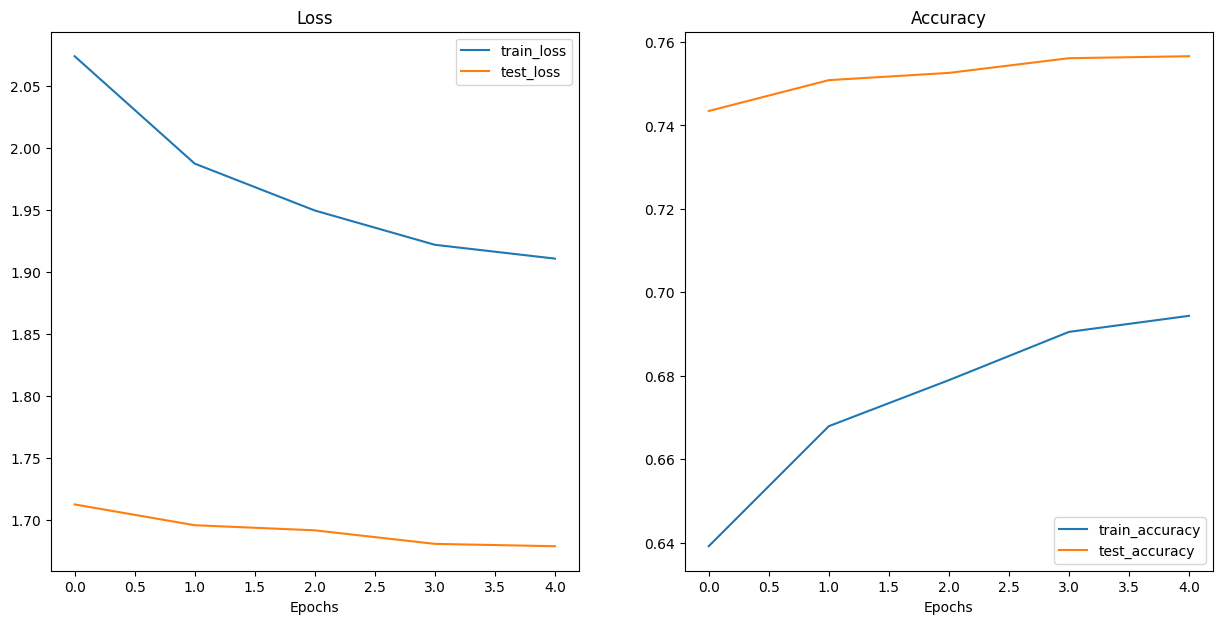

In [34]:
# plot_loss_curves(vit_food_100_percent_results)

# *[NOTE]* For this setup its not worth to run such big dataset on that little ammount of epochs, probably when learning will go for longer (more epochs) time then Loss could be lower and Accuracy higher

# Preparing model to make Demo version

In [67]:
from pytorch_module_dir.modules import utils

# Create a model path
vit_20_percent_data_path = "pretrained_vit_model_20_percent.pth"

# Save model
utils.save_model(model=vit_food101_20_percent,
                target_dir="models",
                model_name=vit_20_percent_data_path)

[INFO] Saving model to: models/pretrained_vit_model_20_percent.pth


In [70]:
# check model size
from pathlib import Path

vit_20_percent_data_size = Path("models", vit_20_percent_data_path).stat().st_size // (1024*1024)
print(f"Pretrained vit food101 model size {vit_20_percent_data_size} MB")

Pretrained vit food101 model size 327 MB


# *[NOTE] Model is a little big. It's not a problem for HuggingFace to host but could be a problem if this app is going to run on old date mobile devices

# Creating dictionaries

In [86]:
# Creating demo directory
from pathlib import Path

# Create demo path
foodvision_demo_path = Path("demos/foodvision_demo")

# Make demo directory
foodvision_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision example directory
example_path = foodvision_demo_path / "examples"
example_path.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Creating demos and example directories")

[INFO] Creating demos and example directories


# Download sample images

In [91]:
import requests

output_directory = example_path

image_list = ["https://raw.githubusercontent.com/DarekW90/photo_sample/main/pizza.jpg",
              "https://raw.githubusercontent.com/DarekW90/photo_sample/main/steak.jpg",
              "https://raw.githubusercontent.com/DarekW90/photo_sample/main/sushi.jpg"]

for url in image_list:
    # set name of file
    image_filename = url.split("/")[-1]
    
    # set path for image
    image_path = output_directory / image_filename

# download example images
    if not image_path.is_file():
        request = requests.get(url)
        with open(image_path, "wb") as f:
                # downloading image from GitHub
                f.write(request.content)
                
        print(f"[INFO] Downloading: {image_path}")
        
    else:
        print(f"[INFO] {image_path} already exists, skipping download")

[INFO] Downloading: demos/foodvision_demo/examples/pizza.jpg
[INFO] Downloading: demos/foodvision_demo/examples/steak.jpg
[INFO] Downloading: demos/foodvision_demo/examples/sushi.jpg


# Move model to demo directory

In [107]:
import shutil

# Create a source path for target model
pretrained_vit_model_path = "models/pretrained_vit_model_20_percent.pth"

# Create destination path for model
pretrained_vit_model_destination = foodvision_demo_path / pretrained_vit_model_path.split("/")[1]

# Try to move files
try:
    print(f"[INFO] Attempting to move {pretrained_vit_model_path} to {foodvision_demo_path}")
    
    # move the model
    shutil.move(src=pretrained_vit_model_path,
               dst=pretrained_vit_model_destination)
    
    print(f"[INFO] Model move complete!")

except:
    print(f"[INFO] No model found at {pretrained_vit_model_path}")
    print(f"[INFO] Model exists at {pretrained_vit_model_destination} : {pretrained_vit_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_vit_model_20_percent.pth to demos/foodvision_demo
[INFO] No model found at models/pretrained_vit_model_20_percent.pth
[INFO] Model exists at demos/foodvision_demo/pretrained_vit_model_20_percent.pth : True


# Create .txt file with all 101 class names

In [109]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [113]:
# Create path to Food101 class names
foodvision_demo_class_names_path = foodvision_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_demo_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to: {foodvision_demo_class_names_path}")
    f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to: demos/foodvision_demo/class_names.txt


# Write model.app 

In this app I'll use ViT_B_16_Weights

In [117]:
%%writefile demos/foodvision_demo/model.py
import torch
import torchvision

from torch import nn

def create_vit_model(num_classes:int=3,
                    seed:int=42):
    """Creates an feature extractor model and transforms"""
    
    # Create weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)
    
    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False
        
    # Change classifier head to suit needs
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))
    
    return model, transforms

Writing demos/foodvision_demo/model.py


# Write app.py

In [119]:
%%writefile demos/foodvision_demo/app.py
# Imports
import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open ("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]
    
# Model and transforms preparation

# Create ViT model
vit_food101, vit_food101_transforms = create_vit_model(num_classes=101)

# Load saved weights
vit_food101.load_state_dict(
    torch.load(f"pretrained_vit_model_20_percent.pth", map_location=torch.device("cpu")))

# Predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction in image and returns predictions."""
    # Start timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = vit_food101_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    vit_food101.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model
        pred_probs = torch.softmax(vit_food101(img),dim=1)
        
    # Create pred label and pred prob dir for each pred
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate pred time
    pred_time=(round(timer() - start_time, 3))
    
    # Return the prediction dict and pred time
    return pred_labels_and_probs, pred_time

# Gradio app

# Create title, desc and art str
title = "FoodVision Demo🔥"
description = "An app made by myself with PyTorch + course papers"
article = "19/02/24 DW"

# Create example list from `examples/` dir
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio Demo app
demo = gr.Interface(fn=predict,
                   inputs=gr.Image(type="pil"),
                   outputs=[gr.Label(num_top_classes=3,label="Predictions"),
                           gr.Number(label="Prediction time(s)")],
                    # Create examples list
                    examples=exampl_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch()

Writing demos/foodvision_demo/app.py


# Download demo app to notebook

In [120]:
try:
    import gradio as gr
except:
    print(f"[INFO] Did not found gradio app... Installing...")
    !pip -q install gradio
    import gradio as gr
print(f"Gradio version: {gr.__version__}")

[INFO] Did not found gradio app... Installing...
Gradio version: 4.19.1


# Write file requirements.txt

In [121]:
# Check current versions

import torch
import torchvision
import gradio as gr

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Gradio version: {gr.__version__}")

Torch version: 2.1.2
Torchvision version: 0.16.2
Gradio version: 4.19.1


19/02/2024

    Torch version: 2.1.2
    Torchvision version: 0.16.2
    Gradio version: 4.19.1

In [122]:
%%writefile demos/foodvision_demo/requirements.txt
torch==2.1.2
torchvision==0.16.2
gradio==4.19.1

Writing demos/foodvision_demo/requirements.txt


In [123]:
!cd demos/foodvision_demo && zip -r ../foodvision_demo.zip * -x "*pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 56%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/sushi.jpg (deflated 0%)
  adding: examples/pizza.jpg (deflated 0%)
  adding: examples/steak.jpg (deflated 0%)
  adding: model.py (deflated 53%)
  adding: pretrained_vit_model_20_percent.pth (deflated 7%)
  adding: requirements.txt (deflated 4%)
